# Задание

Возьмите задачу с винами (https://www.kaggle.com/rajyellow46/wine-quality) и решите ее, оформив в виде CrispDM-подхода. Решение - jupyter notebook на github или colab.

# 1. Бизнес постановка

 Цель - постоить модель, которая будет предсказывать оценку вина исходя из его физикохимических данных.

Используются два набора данных описывающих красный и белый вариант португальского вина "Vinho Verde". Для более подробной информации см. ссылку [Cortez et al., 2009]. Доступны только физико-химические (входные) и сенсорные (выходные) переменные (например, нет данных о типах винограда, марке вина, цене продажи вина и т.д.).

Эти наборы данных можно рассматривать, как задачи классификации или регрессии. Классы упорядочены и не сбалансированы (например, гораздо больше нормальных вин, чем отличных или плохих). Алгоритмы обнаружения выбросов могут быть использованы для обнаружения нескольких отличных или плохих вин.

# 2. Анализ данных

2.1 Библиотеки

In [46]:
import numpy as np
import pandas as pd

from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier

from  sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import itertools

2.2 Загрузка данных и начальный анализ

In [3]:
df = pd.read_csv("winequalityN.csv", header=0)

In [4]:
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [6]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


Перевод заголовков столбцов:

fixed acidity - фиксированная кислотность

volatile acidity - летучая кислотность

citric acid - лимонная кислота

residual sugar - остаточный сахар

chlorides - хлориды

free sulfur dioxide - свободный диоксид серы

total sulfur dioxide - общий диоксид серы

density - плотность

pH - кислотность

sulphates - сульфаты

alcohol - содержание спирта

quality (score between 0 and 10) - качество (оценка от 0 до 10)

Удалим пропущенные значения (т.к. их общее число менее 1% по каждому параметру)

In [9]:
df.dropna(inplace=True)

In [22]:
df.shape

(6463, 13)

В дата сете представлено только 2 типа вина: белое (в преобладающем количестве) и красное, и их оценки имеют нормальное распределение:

Text(0.5, 1.0, 'Оценка вина')

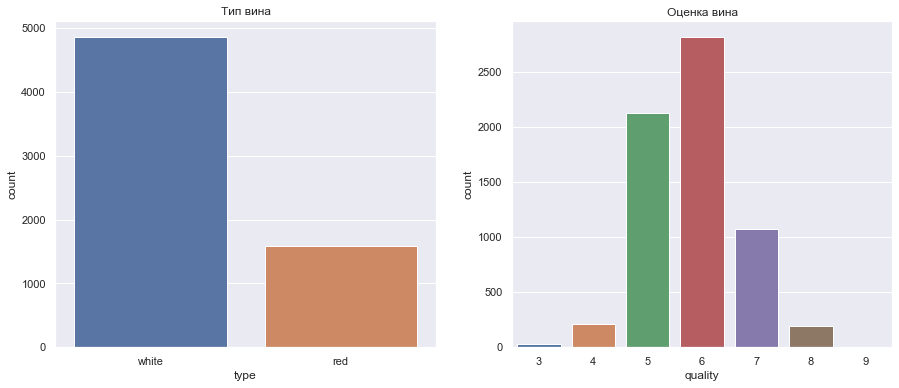

In [14]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

sns.countplot(df["type"], ax=ax[0])
ax[0].set_title("Тип вина")

sns.countplot(df["quality"], ax=ax[1])
ax[1].set_title("Оценка вина")

2.3 Анализ данных на корреляцию признаков

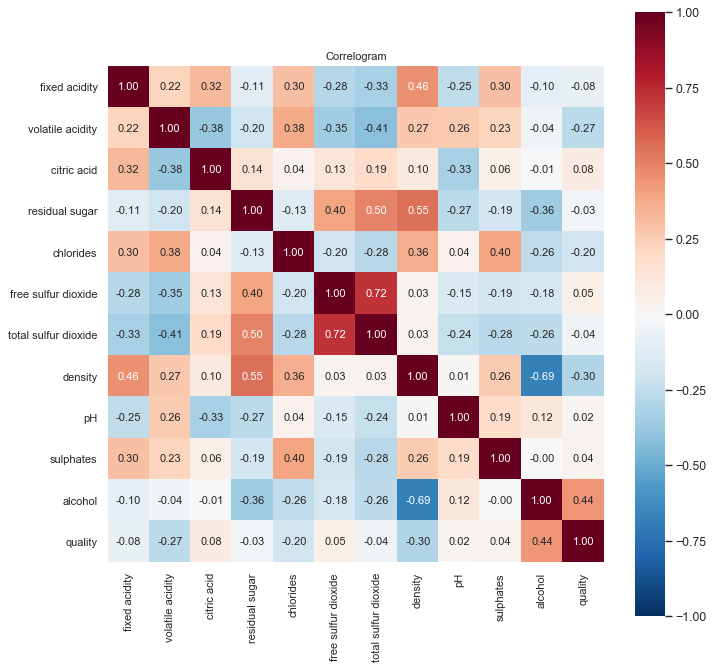

In [18]:
corr_values = df.iloc[:,1:]
plt.figure(figsize=(10,10), dpi= 80)
sns.heatmap(corr_values.corr(),
                cbar=True,
                annot=True,
                square=True,
                cmap="RdBu_r",
                fmt=".2f",
                annot_kws={"size":10},
                yticklabels=corr_values.columns,
                vmax=1,
                vmin=-1,
                center=0)
plt.title('Correlogram', fontsize=10)
plt.show()

Наблюдения:

Сильная корреляция tutal sulfur dioxine - free sulfur dioxine;

Сильная корреляция dencity - residual shugar;

Сильная обратная корреляция dencity - alcohol.

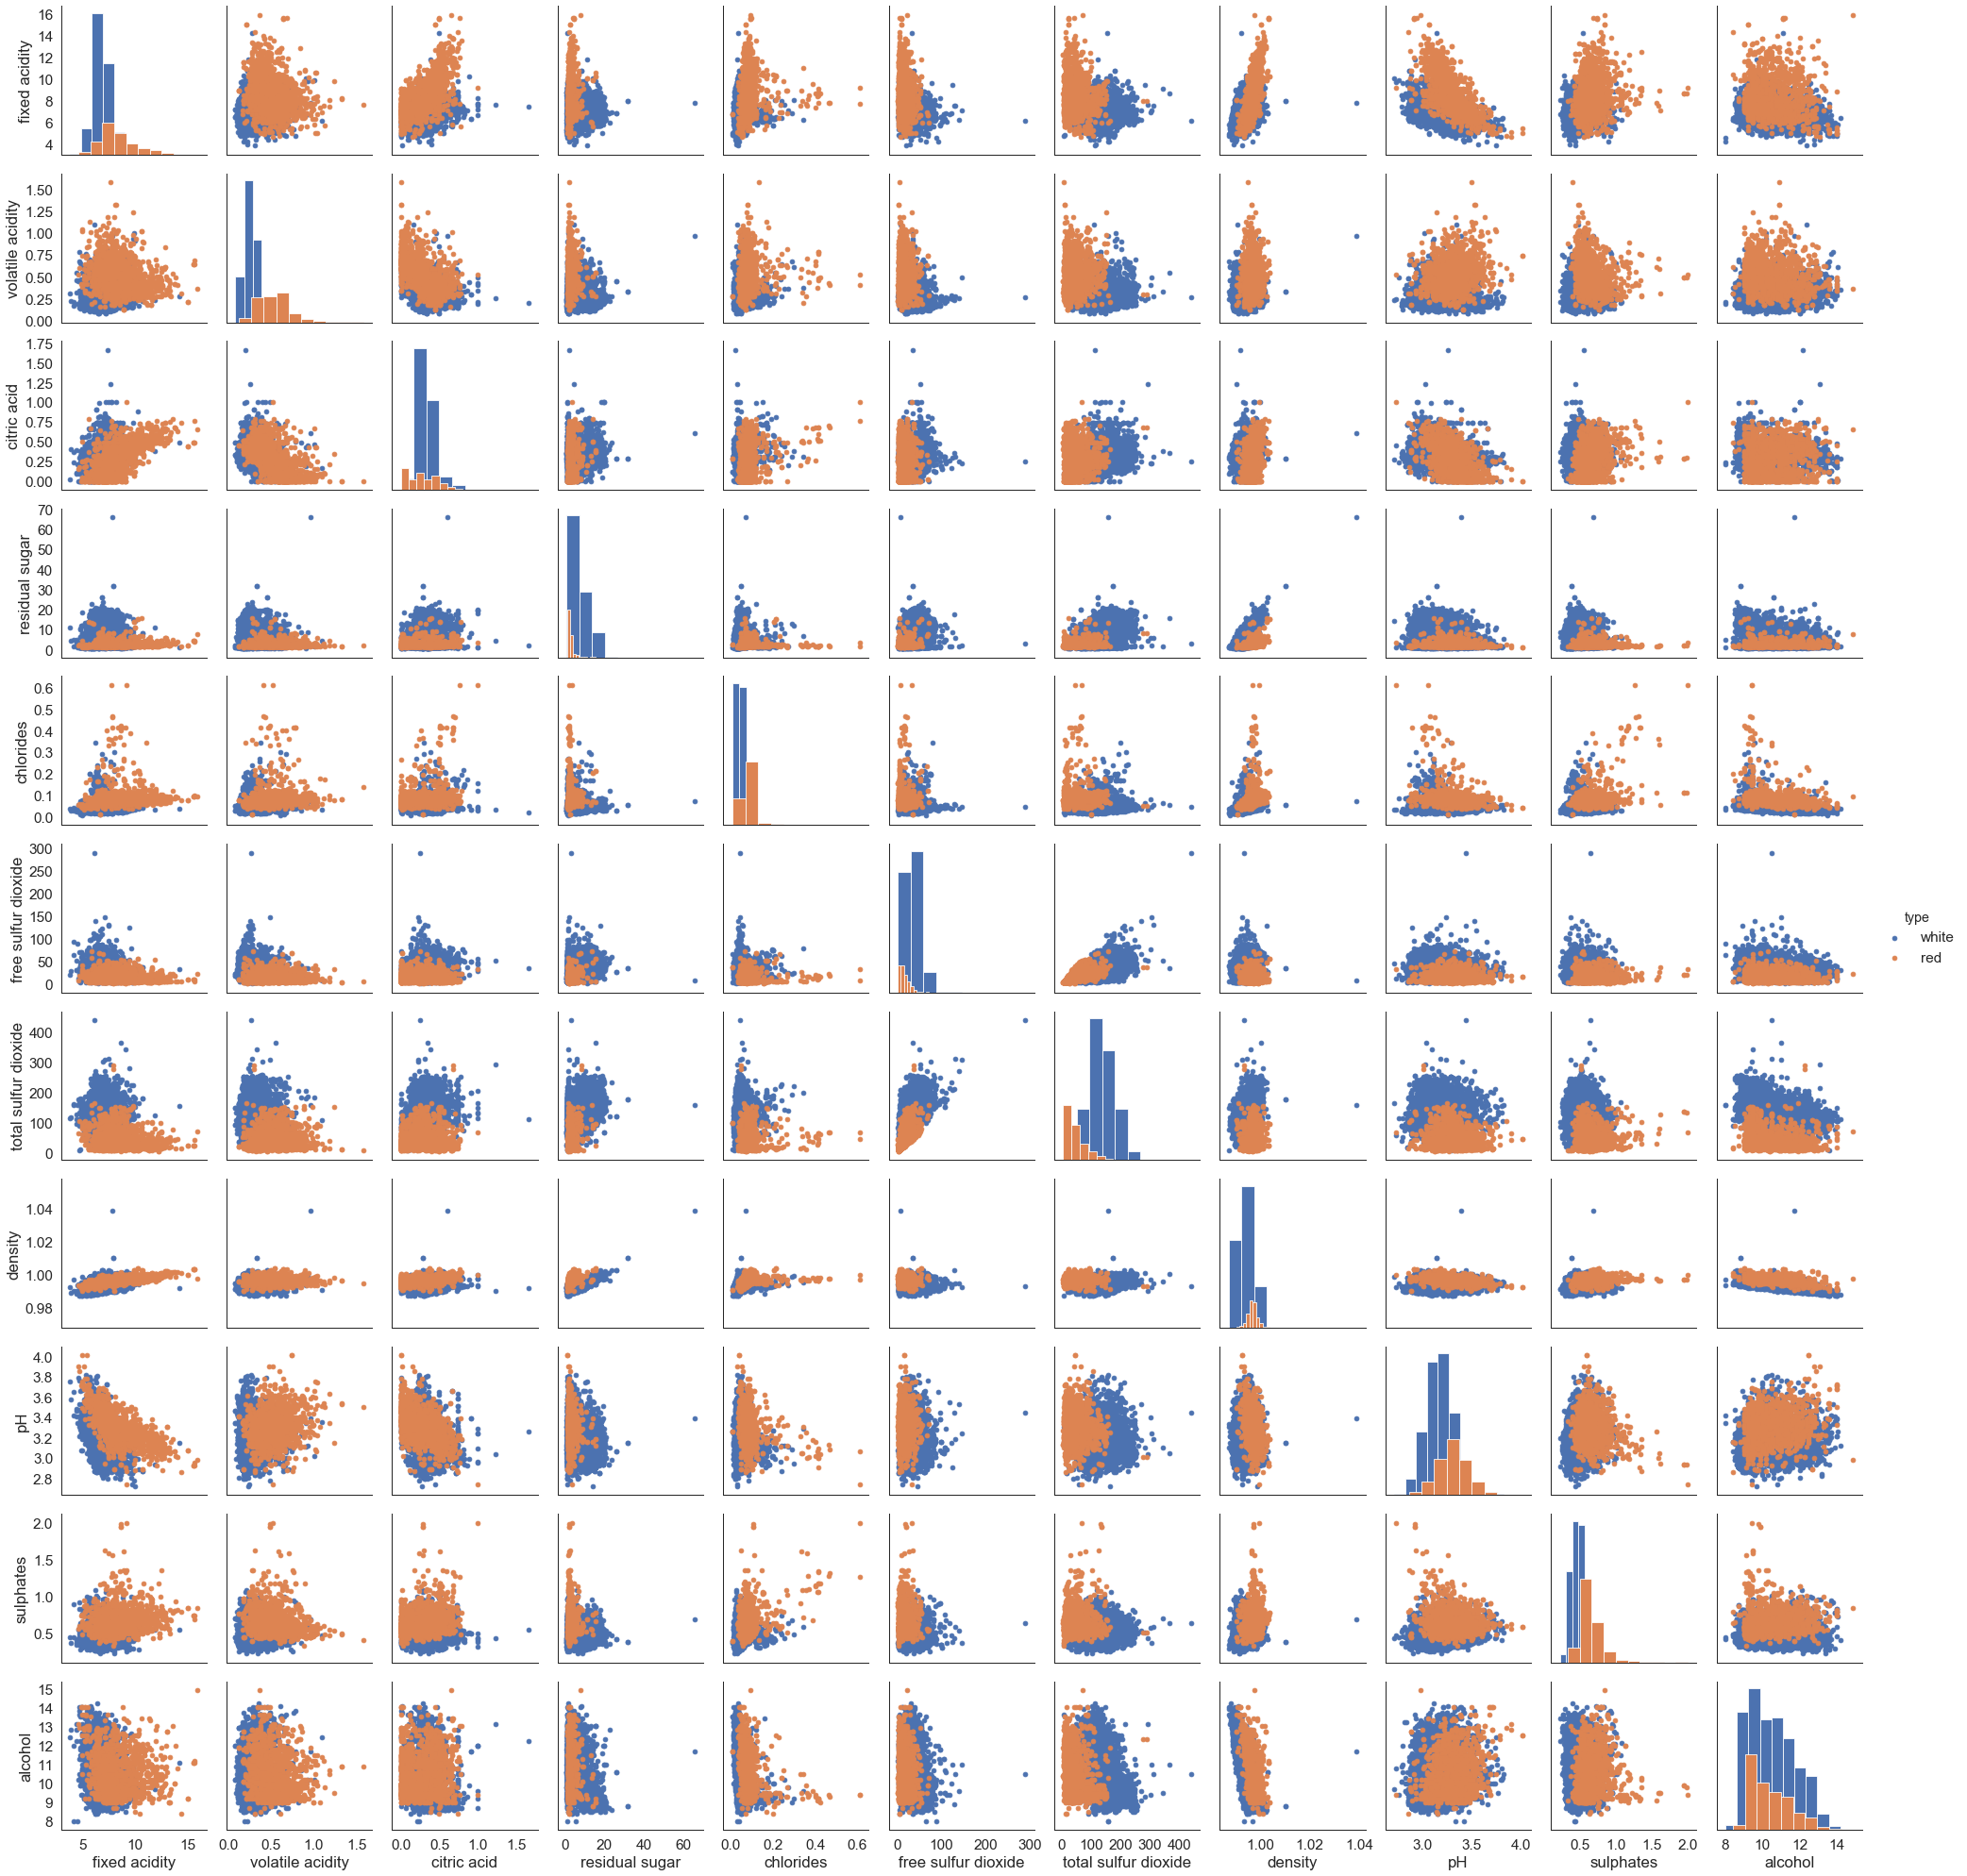

In [19]:
sns.set(style="white", context ="paper",font_scale=1.75)
g = sns.PairGrid(df[df.columns[:-1]], hue="type", diag_sharey=False)
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)
g = g.add_legend()
sns.set(style="white", context ="paper",font_scale=1)

Наблюдения:
    - линейная зависимость dencity;
    - у многих параметров наблюдаются выбросы

# 3. Подготовка данных

3.1 Сгруппируем данные по качеству вин для определение значений итоговых предсказаний

In [35]:
def quality_estim(x):
    if x["quality"] > 6:
        res = 1
    else:
        res = 0
    return res

df["quality_rate"] = df.apply(quality_estim, axis=1)
df["quality_rate"].value_counts()

0    5192
1    1271
Name: quality_rate, dtype: int64

3.2 Составим выборки данных для моделирования

In [36]:
X = df.iloc[:,1:12]
y = df["quality_rate"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

sc = StandardScaler()
sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# 4. Моделирование

4.1 Модель логистической регрессии

In [42]:
log = LogisticRegression()

param_range = [0.001, 0.01, 0.1, 1.0]
penalty = ['l1', 'l2']
param_grid = [{"C":param_range, "penalty":penalty}]

gs_log = GridSearchCV(estimator=log, param_grid=param_grid, scoring="accuracy", cv=10, n_jobs=-1)
gs_log = gs_log.fit(X_train_std, y_train)

print(gs_log.best_score_.round(3))
print(gs_log.best_params_)

0.819
{'C': 1.0, 'penalty': 'l2'}


4.2 Модель дерево решений

In [43]:
tree = DecisionTreeClassifier(max_depth=4, random_state=10)

param_range = [3, 6, 9, 12]
leaf = [10, 15, 20]
criterion = ["entropy", "gini", "error"]
param_grid = [{"max_depth":param_range, "criterion":criterion, "max_leaf_nodes":leaf}]

gs_tree = GridSearchCV(estimator=tree, param_grid=param_grid, scoring="accuracy", cv=10, n_jobs=-1)
gs_tree = gs_tree.fit(X_train, y_train)

print(gs_tree.best_score_.round(3))
print(gs_tree.best_params_)

0.824
{'criterion': 'gini', 'max_depth': 9, 'max_leaf_nodes': 20}


# 5. Оцениваем результаты и планируем внедрение¶

5.1 Результат отработки модели логистической регрессии

In [57]:
y_pred = gs_log.best_estimator_.predict(X_test_std)
print("Logistic Regression RESULTS\n")
print("1. Confusion_matrix = \n", confusion_matrix(y_true=y_test, y_pred=y_pred))
print("2. Accuracy = %.3f" % accuracy_score(y_true=y_test, y_pred=y_pred))
print("3. Precision = %.3f" % precision_score(y_true=y_test, y_pred=y_pred))
print("4. Recall = %.3f" % recall_score(y_true=y_test, y_pred=y_pred))
print("5. f1_score = %.3f" % f1_score(y_true=y_test, y_pred=y_pred))

Logistic Regression RESULTS

1. Confusion_matrix = 
 [[1489   79]
 [ 281   90]]
2. Accuracy = 0.814
3. Precision = 0.533
4. Recall = 0.243
5. f1_score = 0.333


5.2 Результат отработки модели дерево решений

In [58]:
y_pred = gs_tree.best_estimator_.predict(X_test)
print("DecisionTreeClassifier RESULTS\n")
print("1. Confusion_matrix = \n", confusion_matrix(y_true=y_test, y_pred=y_pred))
print("2. Accuracy = %.3f" % accuracy_score(y_true=y_test, y_pred=y_pred))
print("3. Precision = %.3f" % precision_score(y_true=y_test, y_pred=y_pred))
print("4. Recall = %.3f" % recall_score(y_true=y_test, y_pred=y_pred))
print("5. f1_score = %.3f" % f1_score(y_true=y_test, y_pred=y_pred))

DecisionTreeClassifier RESULTS

1. Confusion_matrix = 
 [[1425  143]
 [ 196  175]]
2. Accuracy = 0.825
3. Precision = 0.550
4. Recall = 0.472
5. f1_score = 0.508


Порезультатам исследования рекомендуется к внедрению модель дерево решений.

Для развертывания модели использовать:

In [60]:
y_pred = gs_tree.best_estimator_.predict(X_test)
y_pred = pd.DataFrame(y_pred)
df['y_pred'] = y_pred
df.to_csv( 'wine_prediction_1.csv' , index = False )